In [1]:
# -*- coding: utf-8 -*-
"""
Training a classifier
=====================
This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.
Now you might be thinking,
What about data?
----------------
Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.
-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful
Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.
This provides a huge convenience and avoids writing boilerplate code.
For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.
.. figure:: /_static/img/cifar10.png
   :alt: cifar10
   cifar10
Training an image classifier
----------------------------
We will do the following steps in order:
1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data
1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Using ``torchvision``, it’s extremely easy to load CIFAR10.
"""


'\nTraining a classifier\n=====================\nThis is it. You have seen how to define neural networks, compute loss and make\nupdates to the weights of the network.\nNow you might be thinking,\nWhat about data?\n----------------\nGenerally, when you have to deal with image, text, audio or video data,\nyou can use standard python packages that load data into a numpy array.\nThen you can convert this array into a ``torch.*Tensor``.\n-  For images, packages such as Pillow, OpenCV are useful\n-  For audio, packages such as scipy and librosa\n-  For text, either raw Python or Cython based loading, or NLTK and\n   SpaCy are useful\nSpecifically for vision, we have created a package called\n``torchvision``, that has data loaders for common datasets such as\nImagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,\n``torchvision.datasets`` and ``torch.utils.data.DataLoader``.\nThis provides a huge convenience and avoids writing boilerplate code.\nFor this tutorial, we will use

In [83]:
# for using custom, pre-processed data


In [93]:
import torch
import torchvision
import torchvision.transforms as transforms
import pickle
import numpy as np

%matplotlib inline

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


##########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].#
# We transform them to Tensors of normalized range [-1, 1].              #
##########################################################################
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

#To use original testing data

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)


# To use noisy testing data, uncomment the next three lines

test_batch_noisy = unpickle('./data/cifar-10-batches-py/test_batch_20dB')

features = np.reshape(test_batch_noisy,(10000,32,32,3),'F').astype('uint8')

testset.test_data = features

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(classes)


Files already downloaded and verified
Files already downloaded and verified
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


plane  bird truck horse


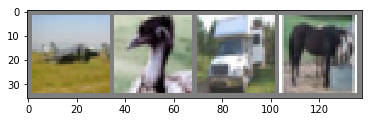

In [94]:
########################################################################
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))




In [95]:
########################################################################
# 2. Define a Convolution Neural Network
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


# Add/remove lines here to add/remove layers in the neural network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [96]:
##################################################################
# Define basis and basis indices for each conv layer 
##################################################################
from Projection.basis_gen import *
import scipy.fftpack

# Conv1
F1 = (net.conv1.weight).size()[0]
H1 = (net.conv1.weight).size()[2]
W1 = (net.conv1.weight).size()[3]
print(F1,H1,W1)

dim1 = np.int(0.5*H1*W1)

basis_indices1 = gen_basis_indices(F1,H1,W1,dim1)


# Conv2
F2 = (net.conv2.weight).size()[0]
H2 = (net.conv2.weight).size()[2]
W2 = (net.conv2.weight).size()[3]
print(F2,H2,W2)

dim2 = np.int(0.5*H2*W2)

basis_indices2 = gen_basis_indices(F2,H2,W2,dim2)
        
    
 # The full basis
basis1 = scipy.fftpack.dct(np.eye(H1*W1),norm='ortho')  
basis2 = scipy.fftpack.dct(np.eye(H2*W2),norm='ortho')    

6 5 5
16 5 5


In [97]:


########################################################################
# 3. Define a Loss function and optimizer
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [98]:
########################################################################
# 4. Train the network

# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.

from Projection.regularization import *

for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        
        w1 = net.conv1.weight.data.numpy()
        w2 = net.conv2.weight.data.numpy()
        
        w1p  = (subspace_projection(dim1,w1,basis1,basis_indices1))
      
        w2p  = (subspace_projection(dim2,w2,basis2,basis_indices2))
    
        
        net.conv1.weight.data = (torch.from_numpy(w1p)).type(torch.FloatTensor)
        net.conv2.weight.data = (torch.from_numpy(w2p)).type(torch.FloatTensor)
        
#         w1n = net.conv1.weight.data.numpy()
#         w2n = net.conv2.weight.data.numpy()
        
        #print(np.linalg.norm(w1 - w1n))
        #print(np.linalg.norm(w2 - w2n))
        
      
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.215
[1,  4000] loss: 1.976
[1,  6000] loss: 1.788
[1,  8000] loss: 1.659
[1, 10000] loss: 1.571
[1, 12000] loss: 1.520
[2,  2000] loss: 1.458
[2,  4000] loss: 1.421
[2,  6000] loss: 1.393
[2,  8000] loss: 1.372
[2, 10000] loss: 1.345
[2, 12000] loss: 1.314
[3,  2000] loss: 1.271
[3,  4000] loss: 1.269
[3,  6000] loss: 1.269
[3,  8000] loss: 1.239
[3, 10000] loss: 1.222
[3, 12000] loss: 1.232
[4,  2000] loss: 1.171
[4,  4000] loss: 1.165
[4,  6000] loss: 1.177
[4,  8000] loss: 1.173
[4, 10000] loss: 1.153
[4, 12000] loss: 1.168
Finished Training


(6, 3, 5, 5)
(5, 5)


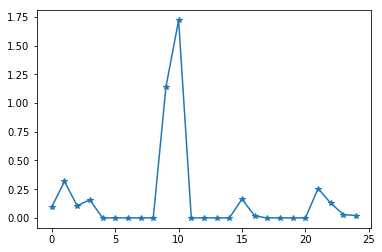

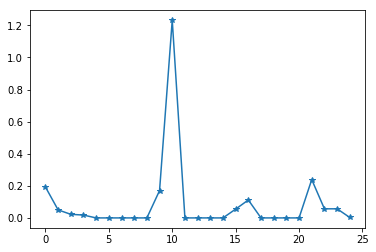

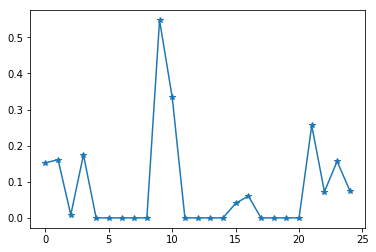

In [99]:
# Verify that the weights lie in the subspace

import scipy
W1 = net.conv1.weight.data.numpy()
print(W1.shape)
basis = scipy.fftpack.dct(np.eye(25),norm='ortho')

fil_1 = W1[4,:,:,:]
fil_1_ch_1 = fil_1[0,:,:]
fil_1_ch_2 = fil_1[1,:,:]
fil_1_ch_3 = fil_1[2,:,:]


print(fil_1_ch_1.shape)

coeff_fil_1_ch_1 = np.dot(basis.T,np.reshape(fil_1_ch_1,25,'F'))
coeff_fil_1_ch_2 = np.dot(basis.T,np.reshape(fil_1_ch_2,25,'F'))
coeff_fil_1_ch_3 = np.dot(basis.T,np.reshape(fil_1_ch_3,25,'F'))

plt.figure()
plt.plot(np.abs(coeff_fil_1_ch_1),'*-')
plt.figure()
plt.plot(np.abs(coeff_fil_1_ch_2),'*-')
plt.figure()
plt.plot(np.abs(coeff_fil_1_ch_3),'*-')

In [100]:
########################################################################
# 5. Test the network on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the network for 2 passes over the training dataset.
# But we need to check if the network has learnt anything at all.
#
# We will check this by predicting the class label that the neural network
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

#dataiter = iter(testloader)
#images, labels = dataiter.next()

# print images
#imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [101]:


########################################################################
# Okay, now let us see what the neural network thinks these examples above are:

outputs = net(Variable(images))

########################################################################
# The outputs are energies for the 10 classes.
# Higher the energy for a class, the more the network
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

########################################################################
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print(correct)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

########################################################################
# That looks waaay better than chance, which is 10% accuracy (randomly picking
# a class out of 10 classes).
# Seems like the network learnt something.
#
# Hmmm, what are the classes that performed well, and the classes that did
# not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Predicted:  plane   dog   car horse
2189
Accuracy of the network on the 10000 test images: 21 %
Accuracy of plane : 27 %
Accuracy of   car :  6 %
Accuracy of  bird : 20 %
Accuracy of   cat : 24 %
Accuracy of  deer : 37 %
Accuracy of   dog :  6 %
Accuracy of  frog : 64 %
Accuracy of horse :  3 %
Accuracy of  ship : 11 %
Accuracy of truck : 18 %


In [ ]:

########################################################################
# Okay, so what next?
#
# How do we run these neural networks on the GPU?
#
# Training on GPU
# ----------------
# Just like how you transfer a Tensor on to the GPU, you transfer the neural
# net onto the GPU.
# This will recursively go over all modules and convert their parameters and
# buffers to CUDA tensors:
#
# .. code:: python
#
#     net.cuda()
#
#
# Remember that you will have to send the inputs and targets at every step
# to the GPU too:
#
# ::
#
#         inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
#
# Why dont I notice MASSIVE speedup compared to CPU? Because your network
# is realllly small.
#
# **Exercise:** Try increasing the width of your network (argument 2 of
# the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
# they need to be the same number), see what kind of speedup you get.
#
# **Goals achieved**:
#
# - Understanding PyTorch's Tensor library and neural networks at a high level.
# - Train a small neural network to classify images
#
# Training on multiple GPUs
# -------------------------
# If you want to see even more MASSIVE speedup using all of your GPUs,
# please check out :doc:`data_parallel_tutorial`.
#
# Where do I go next?
# -------------------
#
# -  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
# -  `Train a state-of-the-art ResNet network on imagenet`_
# -  `Train a face generator using Generative Adversarial Networks`_
# -  `Train a word-level language model using Recurrent LSTM networks`_
# -  `More examples`_
# -  `More tutorials`_
# -  `Discuss PyTorch on the Forums`_
# -  `Chat with other users on Slack`_
#
# .. _Train a state-of-the-art ResNet network on imagenet: https://github.com/pytorch/examples/tree/master/imagenet
# .. _Train a face generator using Generative Adversarial Networks: https://github.com/pytorch/examples/tree/master/dcgan
# .. _Train a word-level language model using Recurrent LSTM networks: https://github.com/pytorch/examples/tree/master/word_language_model
# .. _More examples: https://github.com/pytorch/examples
# .. _More tutorials: https://github.com/pytorch/tutorials
# .. _Discuss PyTorch on the Forums: https://discuss.pytorch.org/
# .. _Chat with other users on Slack: http://pytorch.slack.com/messages/beginner/